 # <font color='orange'>Redes Neuronales (Parte I)</font>

Contamos con una base de datos de una compañía de telecomunicaciones, con la que la misma podrá tomar acciones dirigidas en la retención de clientes propensos a la fuga.

- Aplicaremos "modelo de red neuronal feedforward con una capa oculta, optimizado con Descenso del Gradiente Estocástico.



**Paso 1: Importar librerias** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix,  roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import warnings
warnings.filterwarnings('ignore')


**Paso 2: Carga de base de datos**

In [3]:
df = pd.read_csv("Customer Churn.csv")


df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [5]:
# Exploración inicial

print(df.shape) #Tamaño de dataset
print(df.columns) #Nombre de columnas
df.info() #Resumen general de la estructura del dataset
df.duplicated().sum() # Revisión de duplicados

#Revisión de valores únicos por columna
for col in df.columns:
    print(f"{col}: {df[col].nunique()} valores únicos")

(3150, 14)
Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tar

In [7]:
df.isna().sum().sort_values(ascending=False) #Revisión de valores faltantes

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

Sin valores nulos, podemos seguir con el analisis de distribuición 

<Figure size 1400x1000 with 0 Axes>

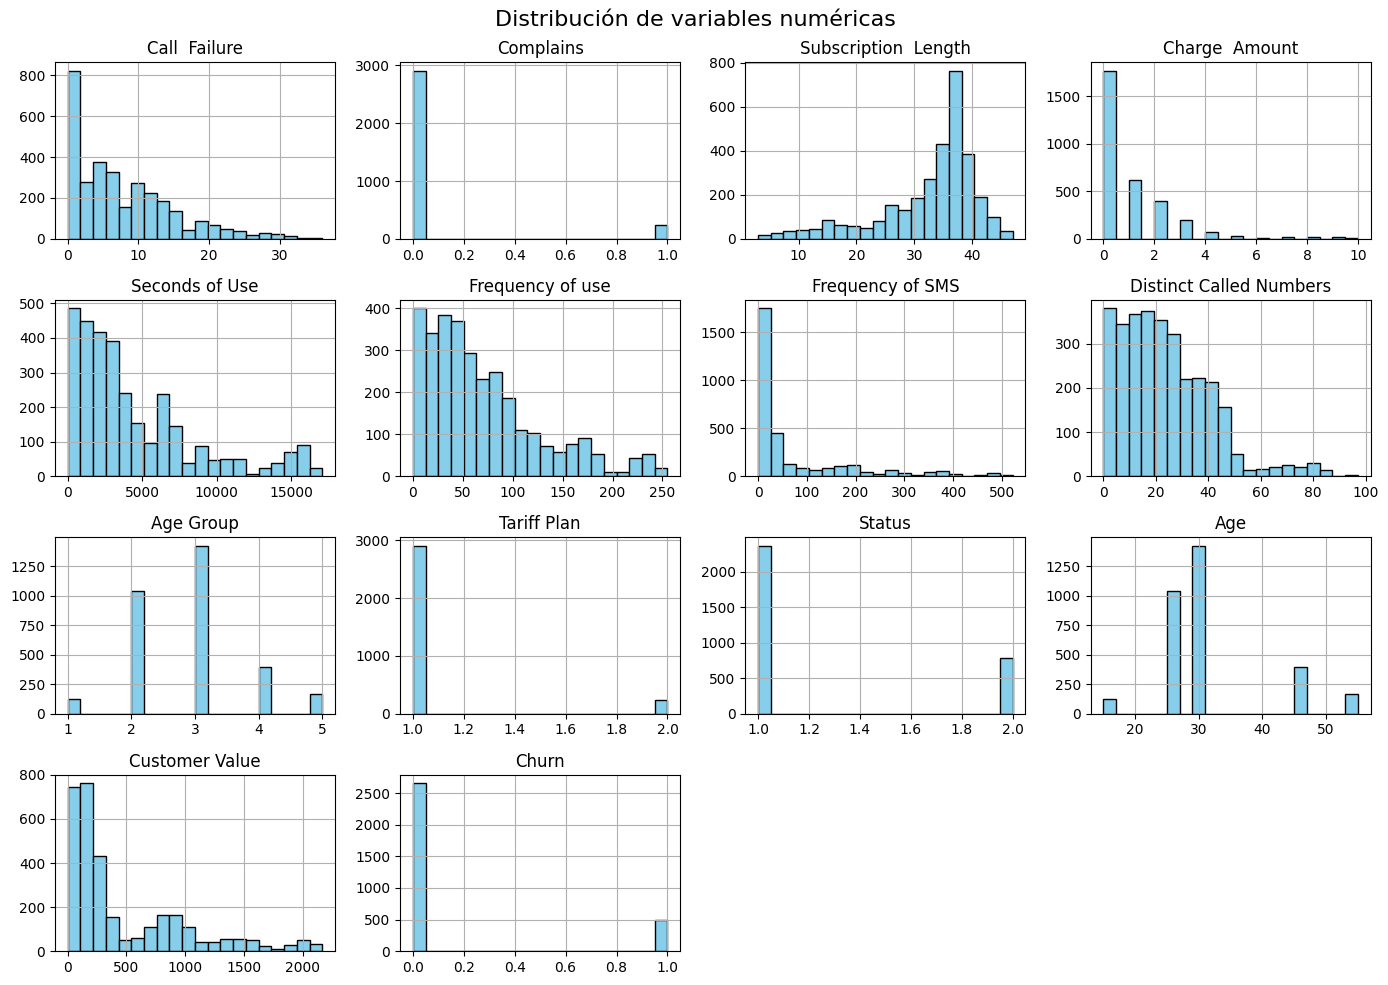

In [9]:
# Histograma para ver distribuición de variables númericas

plt.figure(figsize=(14,10))
df.hist(bins=20, figsize=(14,10), color='skyblue', edgecolor='black')
plt.suptitle('Distribución de variables numéricas', fontsize=16)
plt.tight_layout()
plt.show()


La mayoría de tus variables presentan distribuciones sesgadas a la derecha

**Paso 2: Analizar distribuición de "Subscription Length" para cada clase de "Churn"**

In [14]:
df.groupby('Churn')['Subscription  Length'].describe() #Análisis descriptivo con estadísticas

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,2655.0,32.662524,8.392357,3.0,29.0,35.0,38.0,47.0
1,495.0,31.894949,9.469163,3.0,31.0,35.0,37.0,45.0


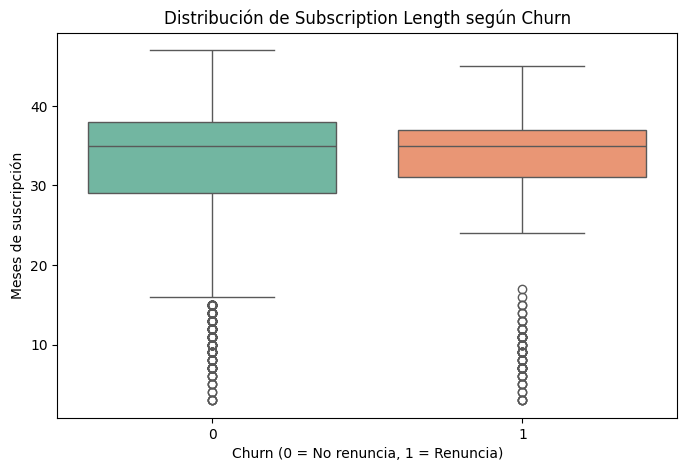

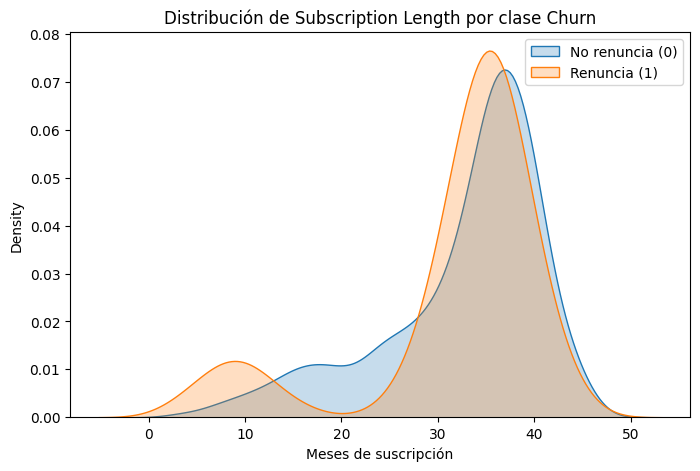

In [16]:
plt.figure(figsize=(8,5)) #Grafico Boxplot
sns.boxplot(data=df, x='Churn', y='Subscription  Length', palette='Set2')
plt.title('Distribución de Subscription Length según Churn')
plt.xlabel('Churn (0 = No renuncia, 1 = Renuncia)')
plt.ylabel('Meses de suscripción')
plt.show()

plt.figure(figsize=(8,5)) #histogramas superpuestos
sns.kdeplot(df[df['Churn']==0]['Subscription  Length'], label='No renuncia (0)', fill=True)
sns.kdeplot(df[df['Churn']==1]['Subscription  Length'], label='Renuncia (1)', fill=True)
plt.title('Distribución de Subscription Length por clase Churn')
plt.xlabel('Meses de suscripción')
plt.legend()
plt.show()

**Conclusión**

La variable Subscription Length presenta una leve relación inversa con la renuncia: los clientes con menos meses de suscripción muestran una ligera mayor tendencia a cancelar el servicio.
Aunque la diferencia promedio no es grande, el análisis visual evidencia una mayor densidad de valores bajos en los clientes que renuncian, lo que sugiere que la antigüedad del cliente podría influir moderadamente en la retención.
En otras palabras, los usuarios más nuevos son un poco más propensos a abandonar el servicio, mientras que los más antiguos tienden a permanecer.

**Paso 3: Preprocesamiento de datos**

In [18]:
# Copia del dataset original
df_prep = df.copy()

# Reconvertir variables binarias de 1/2 a 0/1
df_prep['Tariff Plan'] = df_prep['Tariff Plan'].replace({1: 0, 2: 1})
df_prep['Status'] = df_prep['Status'].replace({1: 0, 2: 1})

# Verificar los cambios
print(df_prep[['Tariff Plan', 'Status']].head())


   Tariff Plan  Status
0            0       0
1            0       1
2            0       0
3            0       0
4            0       0


In [20]:
df_prep.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,0,0,30,197.640,0
1,0,0,39,0,318,5,7,4,2,0,1,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,0,0,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,0,0,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,0,0,15,145.805,0


**Nota:** Se aplicará la estandarización después de dividir los datos en train y test, con el objetivo de evitar data leakage y obtener métricas más realistas del desempeño del modelo

In [22]:
# Separar features (X) y target (y)

X = df_prep.drop('Churn', axis=1)
y = df_prep['Churn']

# División en train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

Conjunto de entrenamiento: (2110, 13)
Conjunto de prueba: (1040, 13)


In [24]:
# Estandarizar variables numéricas (no binarias)

cols_to_scale = [
    'Call  Failure', 'Subscription  Length', 'Charge  Amount',
    'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
    'Distinct Called Numbers', 'Age Group', 'Customer Value'
]

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Ajustar y transformar solo con el entrenamiento

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Aplicar SMOTE solo al conjunto de entrenamiento

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# Verificar balance final de clases

print("\nDistribución original del entrenamiento:")
print(y_train.value_counts(), "\n")

print("Distribución después de SMOTE:")
print(y_train_res.value_counts())


Distribución original del entrenamiento:
Churn
0    1778
1     332
Name: count, dtype: int64 

Distribución después de SMOTE:
Churn
0    1778
1    1778
Name: count, dtype: int64


**Paso 4: Entrenar modelo RandomForest**

Reporte de clasificación (conjunto de test):
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       877
           1       0.82      0.94      0.88       163

    accuracy                           0.96      1040
   macro avg       0.91      0.95      0.93      1040
weighted avg       0.96      0.96      0.96      1040

Top 7 características más importantes:
                   Variable  Importancia
10                   Status     0.142399
5          Frequency of use     0.139169
4            Seconds of Use     0.137179
1                 Complains     0.113569
2      Subscription  Length     0.108019
12           Customer Value     0.086752
7   Distinct Called Numbers     0.079619


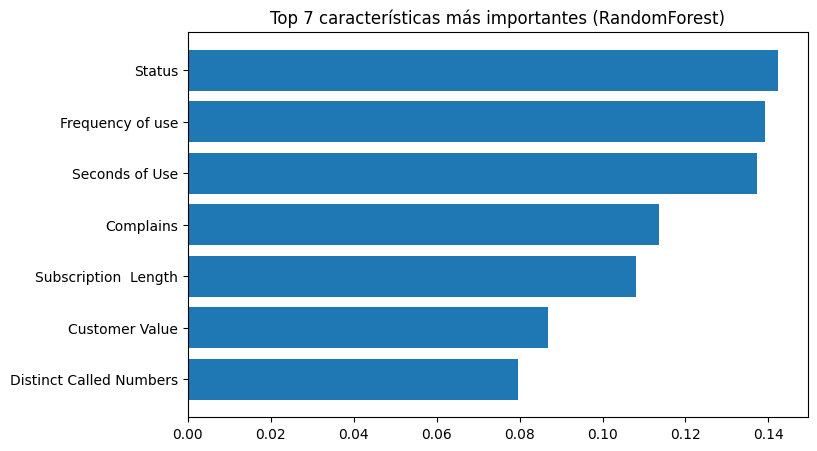

In [27]:
# Entrenamos el modelo con hiperparámetros por defecto

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)

# Predicciones en el conjunto de test

y_pred = rf_model.predict(X_test_scaled)

#  Métricas

print("Reporte de clasificación (conjunto de test):")
print(classification_report(y_test, y_pred))

# Importancias de las variables

importancias = pd.DataFrame({
    'Variable': X_train_res.columns,
    'Importancia': rf_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Mostrar las 7 más importantes

print("Top 7 características más importantes:")
print(importancias.head(7))

#  Visualización

plt.figure(figsize=(8,5))
plt.barh(importancias.head(7)['Variable'], importancias.head(7)['Importancia'])
plt.gca().invert_yaxis()
plt.title('Top 7 características más importantes (RandomForest)')
plt.show()

**Conclusión**

El modelo de Random Forest muestra un desempeño excelente (accuracy 96 %, recall del churn 94 %, F1 = 0.88), siendo capaz de detectar casi todos los clientes propensos a abandonar el servicio. Las variables más relevantes fueron Status, Frequency of Use y Seconds of Use, asociadas al nivel de actividad del cliente.  

El modelo demuestra una alta capacidad de generalización y una buena interpretación de patrones de comportamiento, siendo una base sólida para comparar con otros modelos como redes neuronales.

**Paso 5: Entrenar modelo de red neuronal feedforward**

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

AUC obtenido: 0.947


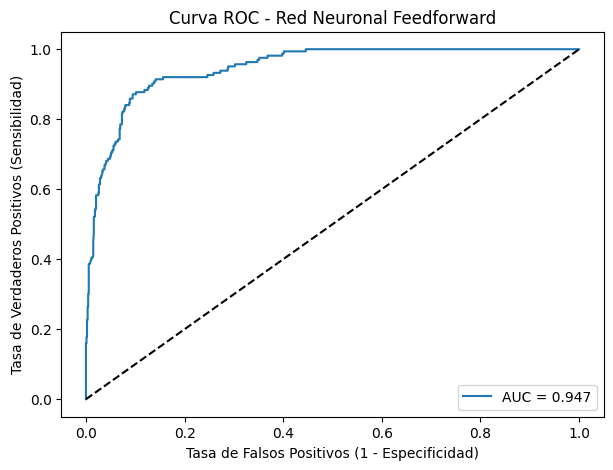

In [37]:
# Seleccionar las 7 características más importantes
top_features = [
    'Status',
    'Frequency of use',
    'Seconds of Use',
    'Complains',
    'Subscription  Length',
    'Customer Value',
    'Distinct Called Numbers'
]

# Filtrar conjuntos de entrenamiento y prueba
X_train_top = X_train_res[top_features]
X_test_top = X_test_scaled[top_features]

# Crear y entrenar red neuronal
model = Sequential([
    Dense(8, input_dim=X_train_top.shape[1], activation='relu'),
    Dense(1, activation='sigmoid')
])

# Optimizador: Gradiente Descendente Estocástico (SGD)
optimizer = SGD(learning_rate=0.01)

# Compilación del modelo
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])

# Entrenar el modelo
history = model.fit(
    X_train_top, y_train_res,
    epochs=100,               # se puede ajustar entre 100 y 200
    batch_size=32,
    validation_data=(X_test_top, y_test),
    verbose=0
)

# Predicciones de probabilidad (entre 0 y 1)
y_pred_prob = model.predict(X_test_top)

# Calcular AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC obtenido: {auc:.3f}")

#  Curva ROC

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC - Red Neuronal Feedforward')
plt.legend(loc='lower right')
plt.show()



**Conclusión**

La red neuronal feedforward con una capa oculta (8 neuronas, activación ReLU y optimizador SGD) alcanzó un AUC = 0.947 en el conjunto de validación, superando ampliamente el objetivo del 90%.
Esto confirma que el modelo es capaz de capturar relaciones no lineales entre las variables seleccionadas y el comportamiento de abandono de clientes (churn).
La curva ROC muestra una alta sensibilidad con una baja tasa de falsos positivos, lo que indica excelente discriminación entre clases.